# Лабораторная работа №2 Введение в pytorch

## Сергеев Никита Вариант 16

In [1]:
import torch
import numpy as np

In [2]:
x = np.arange(16).reshape(4, 4)

print(f'X :\n {x}')
print(f'add 5 :\n {x + 5}')
print(f'X*X^T  :\n {np.dot(x, x.T)}')
print(f'mean over cols :\n {x.mean(axis=-1)}')
print(f'cumsum of cols :\n {np.cumsum(x, axis=0)}' )

X :
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
add 5 :
 [[ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]
 [17 18 19 20]]
X*X^T  :
 [[ 14  38  62  86]
 [ 38 126 214 302]
 [ 62 214 366 518]
 [ 86 302 518 734]]
mean over cols :
 [ 1.5  5.5  9.5 13.5]
cumsum of cols :
 [[ 0  1  2  3]
 [ 4  6  8 10]
 [12 15 18 21]
 [24 28 32 36]]


In [3]:
x = torch.linspace(0, 2 * np.pi, 16, dtype=torch.float64)

In [4]:
# Задача: вычислите вектор sin^2(x) + cos^2(x)

out = torch.sin(x)**torch.sin(x) + torch.cos(x)**torch.cos(x)

print(out.numpy())

[2.         1.61428996 1.5662919  1.64905341        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan]


In [5]:
a = torch.tensor(2.0, requires_grad=True)
loss = 8*a**4+3*a**3+7*a**2+6*a+3

loss.backward()
a.grad

tensor(326.)

### Leaf vs Non-leaf Variable:

```
x = torch.tensor([1., 2., 3., 4.], requires_grad=True))  # leaf tensor
y = x + 1  # not a leaf variable
```

Градиенты будут сохранены и доступны для использования только для `leaf tensor`.
Такое поведение по-умолчанию сделано ради экономии памяти. Все тензоры с флагом `requires_grad = False` считаются`leaf tensors` по умолчанию.

Чтобы выставить флаг `requires_grad=False` и выключить автоматическое вычисление градиентов для нескольких тензоров, можно использовать `with torch.no_grad()` или `detach`:

In [6]:
x = torch.tensor([1.], requires_grad=True)
y = x**2
print(x.requires_grad)
print(y.requires_grad)

with torch.no_grad():
    z = torch.exp(x)
    print(z.requires_grad)
    
# detach from the graph
w = torch.log(x).detach()
print(w.requires_grad)

True
True
False
False


## Пример линейной регрессии на датасете California

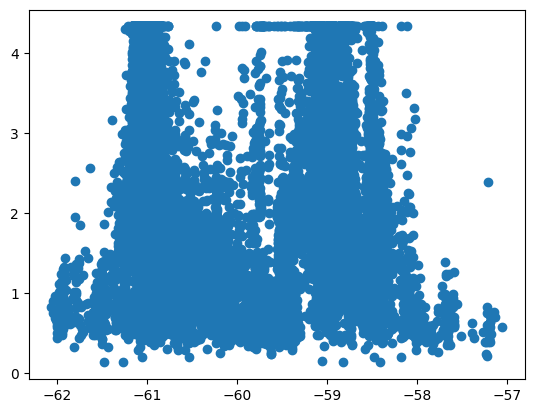

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

#select one column for simplicity. 
x = X[:, -1] / X[:, -1].std()
y = y / y.std()

plt.scatter(x, y);

In [8]:
# model tensors
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# data tensors
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# все тензоры являются leaf-tensors
# x и y не требуют вычисления градиентов
for vv in [w, b, x, y]:
    print(vv.is_leaf, vv.requires_grad)

True True
True True
True False
True False


In [9]:
y_pred = w * x + b
loss = torch.mean((y_pred - y)**2)

loss.backward()

#now w.grad is a tensor containing gradient of L w.r.t. w

print("dL/dw = \n", w.grad)
print("dL/db = \n", b.grad)

# no gradients for tensors with requires_grad=False
# and non-leaf tensors
print("Non-Leaf x dL/dx = \n", x.grad)
print("Non-Leaf loss dL/dpred = \n", y_pred.grad)

dL/dw = 
 tensor([214.0627])
dL/db = 
 tensor([-3.5852])
Non-Leaf x dL/dx = 
 None
Non-Leaf loss dL/dpred = 
 None


C:\Users\nmser\AppData\Local\Temp\ipykernel_27032\565857936.py:14: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten\src\ATen/core/TensorBody.h:494.)
  print("Non-Leaf loss dL/dpred = \n", y_pred.grad)


Градиенты промежуточных функций

In [10]:
y_pred = w * x + b

# check this:
y_pred.retain_grad()

loss = torch.mean((y_pred - y)**2)
loss.backward()

print("Non-Leaf loss dL/dpred = \n", y_pred.grad[:10])

Non-Leaf loss dL/dpred = 
 tensor([-0.0004, -0.0003, -0.0003, -0.0003, -0.0003, -0.0002, -0.0003, -0.0002,
        -0.0002, -0.0002])


линейная регрессия

Почему-то не видно графика линейной регрессии

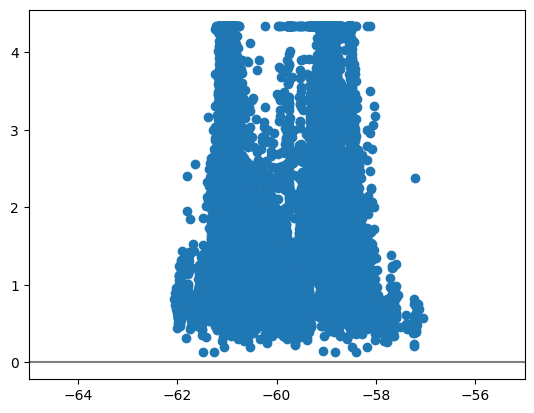

loss =  nan


In [11]:
%matplotlib inline
from IPython.display import clear_output

for i in range(100):
    
    # Вычисляем предсказание и потерю
    y_pred = w * x  + b
    loss = torch.mean((y_pred - y)**2)
    
    # Обратное распространение
    loss.backward()
    
    # Шаг градиентного спуска для весов
    with torch.no_grad():  # Важно, чтобы обновление весов не учитывалось при вычислении градиентов
        w -= 0.1 * w.grad
        b -= 0.1 * b.grad
    
    # Обнуляем градиенты
    w.grad.zero_()
    b.grad.zero_()
    
    # Визуализация результатов
    if (i + 1) % 5 == 0:
        clear_output(True)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.scatter(x.numpy(), y.numpy())
        plt.plot(x.numpy(),y_pred.data.numpy(),color='orange')
        plt.xlim(-65, -55) 
        plt.show()

        print("loss = ", loss.item())
        if loss.item() < 0.5:
            print("Done!")
            break


оптимизаторы

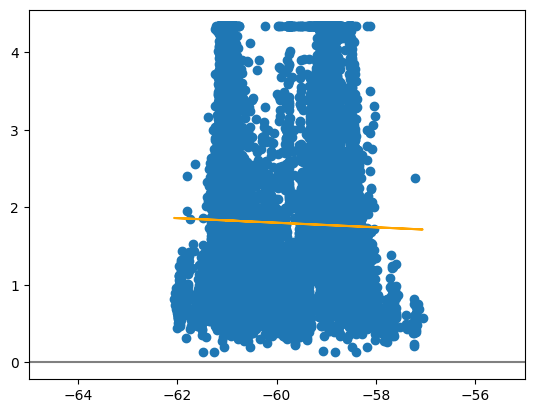

loss =  0.9981564283370972


In [12]:
# from sklearn.datasets import load_boston

# датасет load_boston был удален по этическим соображениям, поэтому используем fetch_california_housing
x, y = fetch_california_housing(return_X_y=True)
x = x[:, -1] / x[:, -1].std()
y = y / y.std()

# data tensors
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# model tensors
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# define optimizer
opt = torch.optim.RMSprop([w, b], lr=0.1)

for i in range(100):
    y_pred = w * x + b
    loss = torch.mean((y_pred - y) ** 2) #######
    
    # backprop and gradient descent
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    #the rest of code is just bells and whistles
    if (i + 1) % 5 == 0:
        #draw linear regression prediction vs data
        clear_output(True)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.scatter(x.numpy(), y.numpy())
        plt.plot(x.numpy(), y_pred.data.numpy(), color='orange')
        plt.xlim(-65, -55) 
        plt.show()

        print("loss = ", loss.item())
        if loss.item() < 0.5:
            print("Done!")
            break

## Высокоуровневые API 

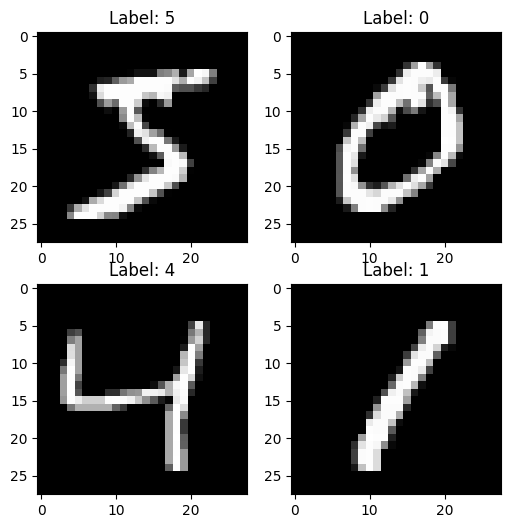

In [13]:
# MNIST 
from util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title(f"Label: {y_train[i]}")
    plt.imshow(X_train[i].reshape([28, 28]), cmap='gray');

In [14]:
# Higher-level API:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, hidden_size=40):
        super(Net, self).__init__()
        # here you construct weights for layers
        self.fc1 = nn.Linear(X_train.shape[1], hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)
        
    def forward(self, x):
        # here you describe usage of layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # check log_softmax signature
        return F.log_softmax(x, dim=-1)
    # backward function computes automaticaly

In [15]:
# model interface:
model = Net()
tt = torch.from_numpy(X_train[:10, :].astype(np.float32))
output = model(tt)

print('Model outputs: \n', output)
# Получаем вероятности из output с помощью экспоненциальной функции, поскольку output - это логарифм вероятностей
probs = torch.exp(output)
print('Probs: \n', probs)

# Получаем предсказания из output, выбирая индекс с наибольшим значением в каждой строке
# Это эквивалентно выбору класса с наибольшей вероятностью
pred = torch.argmax(output, dim=1)
print('Pred: \n', pred.data.numpy())
print('Truth: \n', y_train[:10])

Model outputs: 
 tensor([[-2.3048, -2.1190, -2.3689, -2.3522, -2.1962, -2.4257, -2.4270, -2.4138,
         -2.1955, -2.2769],
        [-2.3070, -2.1044, -2.3852, -2.3585, -2.2245, -2.4330, -2.4172, -2.4172,
         -2.1764, -2.2614],
        [-2.3072, -2.1221, -2.3551, -2.3536, -2.2050, -2.4379, -2.4136, -2.4004,
         -2.2164, -2.2632],
        [-2.2857, -2.1339, -2.3672, -2.3516, -2.1769, -2.4328, -2.4314, -2.4053,
         -2.2085, -2.2851],
        [-2.2966, -2.1244, -2.3664, -2.3452, -2.2009, -2.4342, -2.4211, -2.4139,
         -2.1867, -2.2896],
        [-2.3117, -2.1321, -2.3718, -2.3479, -2.1908, -2.4436, -2.4241, -2.3948,
         -2.2026, -2.2587],
        [-2.2899, -2.1308, -2.3683, -2.3416, -2.1802, -2.4296, -2.4189, -2.4211,
         -2.1960, -2.3028],
        [-2.3284, -2.0911, -2.3771, -2.3727, -2.2148, -2.4036, -2.4179, -2.4249,
         -2.1988, -2.2553],
        [-2.2933, -2.1363, -2.3574, -2.3373, -2.1921, -2.4345, -2.4279, -2.4216,
         -2.1967, -2.2805],
  

Тренировка сети

In [16]:
from IPython.display import clear_output
from tqdm.auto import tqdm

# функция для итераций по минибатчам
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [17]:
def train(model, optimizer, batchsize=32):
    loss_log = []
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        # data preparation
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        # compute gradients
        loss.backward()
        # make a step
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log


# TODO: написать функцию для валидации по X_val, y_val
# hint: optimizer не нужен
def test(model):
    loss_log = []
    model.eval()# переключаем модель в режим предсказания
    with torch.no_grad():  # отключаем вычисление градиентов
        for x_batch, y_batch in iterate_minibatches(X_val, y_val, batchsize=32, shuffle=False):
            data = torch.from_numpy(x_batch.astype(np.float32))
            target = torch.from_numpy(y_batch.astype(np.int64))
            output = model(data)
            loss = F.nll_loss(output, target)  # вычисляем потерю
            loss_log.append(loss.item())  # сохраняем значение потери
    return np.mean(loss_log)  # возвращаем среднее значение потери на валидационном наборе

Визуализация истории обучения

In [18]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.plot(train_history, label='train')
    plt.plot(np.linspace(0, len(train_history), len(val_history)), val_history, label='val', color='orange')
    plt.title(title)
    plt.xlabel('Training steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Обучение и визуализация результатов

Epoch 10
Train loss: 0.061911319675017625
Val loss: 0.1083158493304673


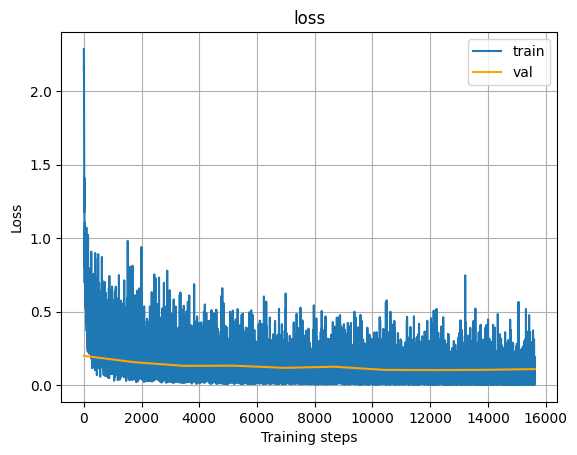

In [19]:
train_log = []
val_log = []

model = Net()
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
batchsize = 32

for epoch in range(10):
    train_loss = train(model, opt, batchsize=batchsize)
    train_log.extend(train_loss)
    
    val_loss = np.mean(test(model))
    val_log.append(val_loss)  # сохраняем среднее значение потери на валидации
    
    clear_output(wait=True)
    print(f"Epoch {epoch+1}")
    print(f"Train loss: {np.mean(train_loss)}")
    print(f"Val loss: {val_loss}")
    plot_history(train_log, val_log)  # визуализируем историю обучения

## Метрики

Epoch 10
Train loss: 0.061661886308648085, Train accuracy: 0.9808938860435339
Val loss: [0.023227760568261147, 0.026625394821166992, 0.47001683712005615, 0.008267383091151714, 0.006208207458257675, 0.021413106471300125, 0.1382865011692047, 0.45855411887168884, 0.025332918390631676, 0.03431079536676407, 0.24857524037361145, 0.26351895928382874, 0.09925540536642075, 0.21727627515792847, 0.2531352639198303, 0.004867013078182936, 0.726193368434906, 0.07227785140275955, 0.056056566536426544, 0.033912379294633865, 0.019183769822120667, 0.05475565791130066, 0.3663880527019501, 0.20160245895385742, 0.0508849136531353, 0.05736222863197327, 0.07406226545572281, 0.2737652659416199, 0.05642255023121834, 0.017968792468309402, 0.004958197008818388, 0.1278752088546753, 0.01230547484010458, 0.04673211649060249, 0.005392493214458227, 0.004012765362858772, 0.23354731500148773, 0.02818569540977478, 0.09368064999580383, 0.3242550492286682, 0.37161725759506226, 0.07844431698322296, 0.0877864882349968, 0.23

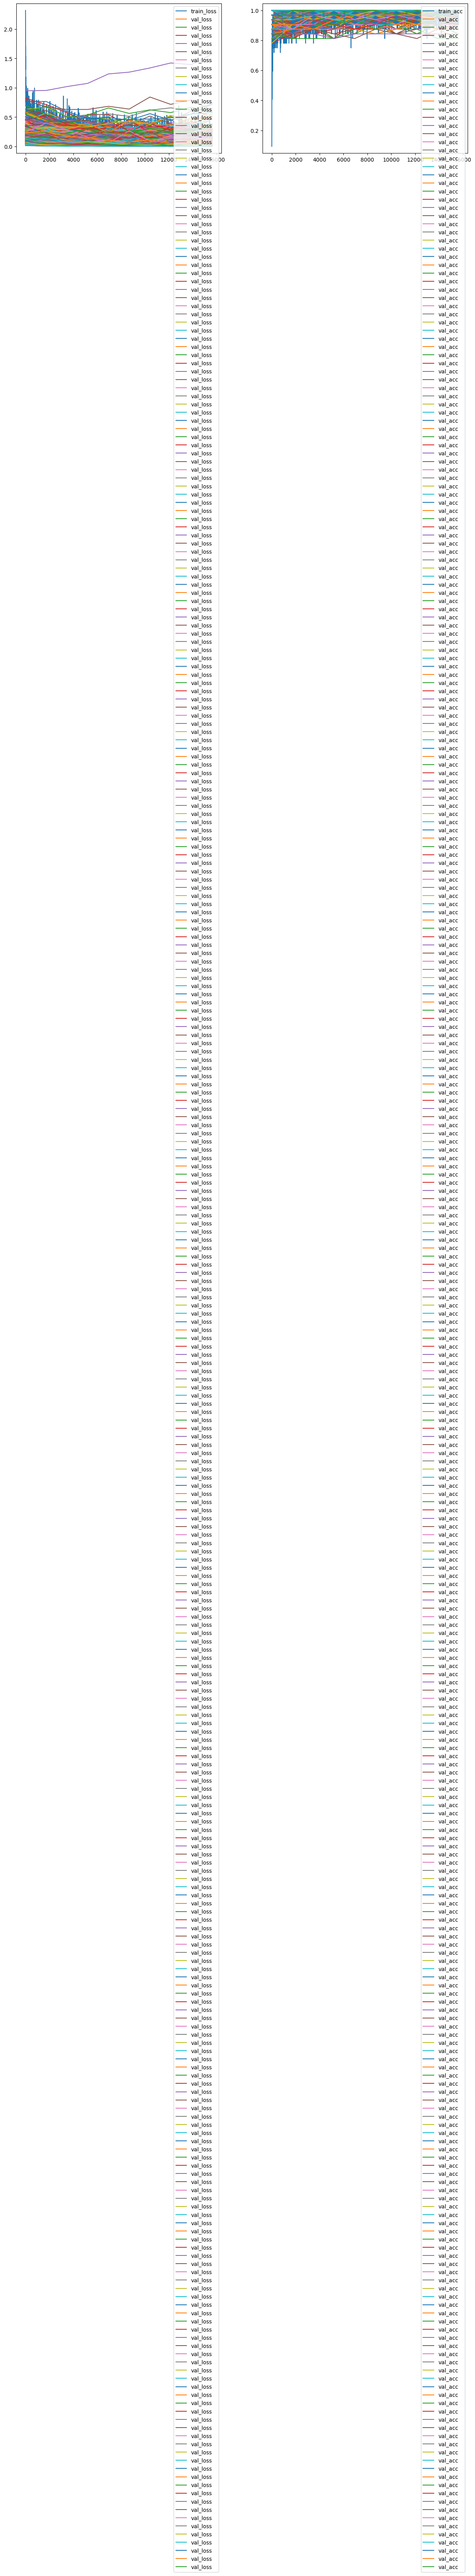

In [20]:
def train(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(output, dim=1)
        accuracy = torch.mean((preds == target).float())
        
        loss_log.append(loss.item())
        acc_log.append(accuracy.item())
    
    return loss_log, acc_log


def test(model):
    loss_log, acc_log = [], []
    
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in iterate_minibatches(X_val, y_val, batchsize=32, shuffle=False):
            data = torch.from_numpy(x_batch.astype(np.float32))
            target = torch.from_numpy(y_batch.astype(np.int64))
            
            output = model(data)
            loss = F.nll_loss(output, target)
            
            preds = torch.argmax(output, dim=1)
            accuracy = torch.mean((preds == target).float())
            
            loss_log.append(loss.item())
            acc_log.append(accuracy.item())
    
    return loss_log, acc_log



def plot_history(loss_log, acc_log, val_loss_log, val_acc_log):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_log, label='train_loss')
    plt.plot(np.linspace(0, len(loss_log), len(val_loss_log)), val_loss_log, label='val_loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(acc_log, label='train_acc')
    plt.plot(np.linspace(0, len(acc_log), len(val_acc_log)), val_acc_log, label='val_acc')
    plt.legend()
    
    plt.show()


train_log, train_acc_log = [], []
val_log, val_acc_log = [], []

model = Net()
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
batchsize = 32


for epoch in range(10):
    train_loss, train_acc = train(model, opt, batchsize=batchsize)
    val_loss, val_acc = test(model)
    
    train_log.extend(train_loss)
    train_acc_log.extend(train_acc)
    val_log.append(val_loss)
    val_acc_log.append(val_acc)
    
    clear_output(wait=True)
    print(f"Epoch {epoch+1}")
    print(f"Train loss: {np.mean(train_loss)}, Train accuracy: {np.mean(train_acc)}")
    print(f"Val loss: {val_loss}, Val accuracy: {val_acc}")
    plot_history(train_log, train_acc_log, val_log, val_acc_log)
    

### Загрузчик данных

In [1]:
%matplotlib inline

import time
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()
plt.ion()

S:\study\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


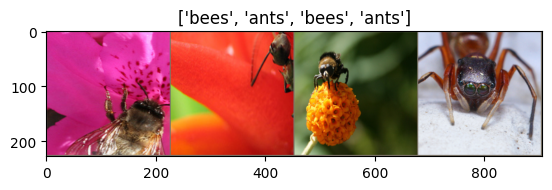

In [2]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
 # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels).type(torch.float)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        time_elapsed = time.time() - since
        print('Elapsed {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [4]:
# torchvision содержит ряд моделей с претрейненными весами:
[m for m in dir(models) if not m.startswith('_')]

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [5]:
model_ft = models.resnet18(pretrained=True)
# hint: вы можете изучить устройство любого объекта в python пользуясь интерактивностью интерпретатора и методом dir()

# Список слоев модели можно получить с помощью обхода
# for x in model_ft.named_modules():
#    print(x[0], x[1])


# TODO: подмените в модели последний слой, чтобы она работала для двух классов

from torchvision import models
import torch.nn as nn

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)


# TODO: выберите, какие параметры дообучать. Результат получается лучше если дообучать всё или только последний слой? Почему?
# например, выключить обучение всех параметров можно при помощи этого кода:

for param in model_ft.parameters():
    param.requires_grad = False

# Только параметры последнего слоя участвуют в обучении
params_to_train = model_ft.fc.parameters()

# use GPU if you have it
if use_gpu:
    model_ft = model_ft.cuda()

# loss
criterion = nn.CrossEntropyLoss()

# Create optimizer on the selected parameters
optimizer_ft = optim.SGD(params_to_train, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
# если всё сделано правильно, то точность на валидации должна быть больше 94%

Epoch 0/24
----------


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
# TODO: напишите функцию, прогоняющую модель на нескольких примерах из валидационной выборки
# Отобразите картинки и предсказания

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

            
visualize_model(model_ft)